<a href="https://www.kaggle.com/code/kelixirr/cats-vs-dogs-keras-example-project-deep-learning?scriptVersionId=137551198" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# raw data download
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  58.2M      0  0:00:13  0:00:13 --:--:-- 61.5M41  323M    0     0  50.9M      0  0:00:15  0:00:06  0:00:09 51.1M


In [4]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   __notebook_source__.ipynb   'readme[1].txt'
 PetImages		   kagglecatsanddogs_5340.zip


In [5]:
!ls PetImages

Cat  Dog


In [6]:
# filter out the corruputed images
import os 

num_skipped = 0 

for folder_name in ("Cat", "Dog"):
    
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
            
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
            
            
print(f"Number of Deleted Images: {num_skipped}")

Number of Deleted Images: 1590


In [7]:
# generate dataset 

image_size = (180, 180)
batch_size = 128 

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset = "both", 
    seed = 42,
    image_size = image_size,
    batch_size = batch_size
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


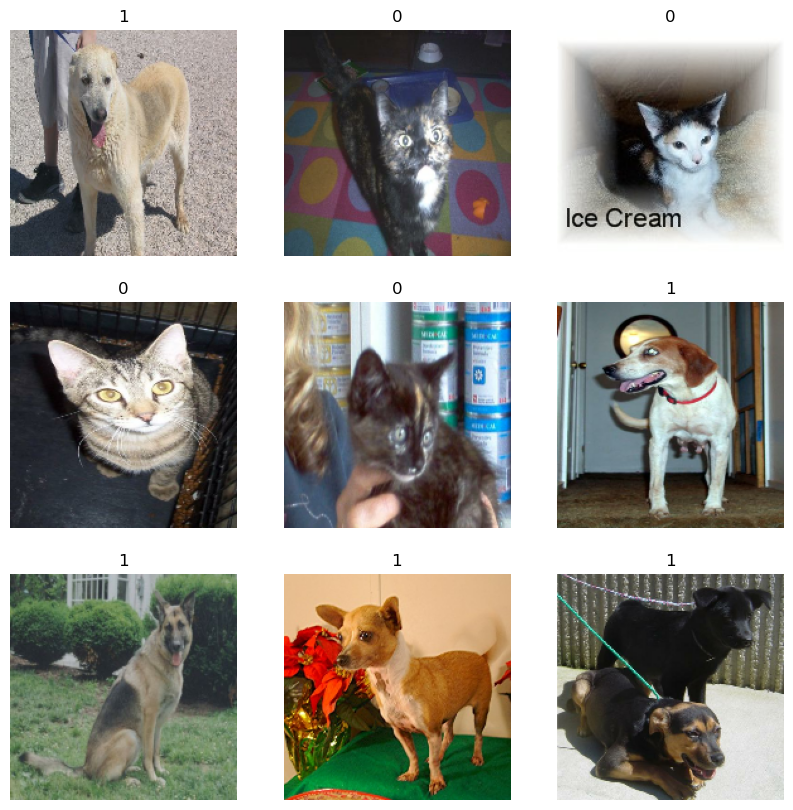

In [8]:
# Visualize the data 
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(int(labels[i]))
        plt.axis("off")

In [9]:
# Introducing Data Augementation 

data_augmentation = keras.Sequential([
    
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
])

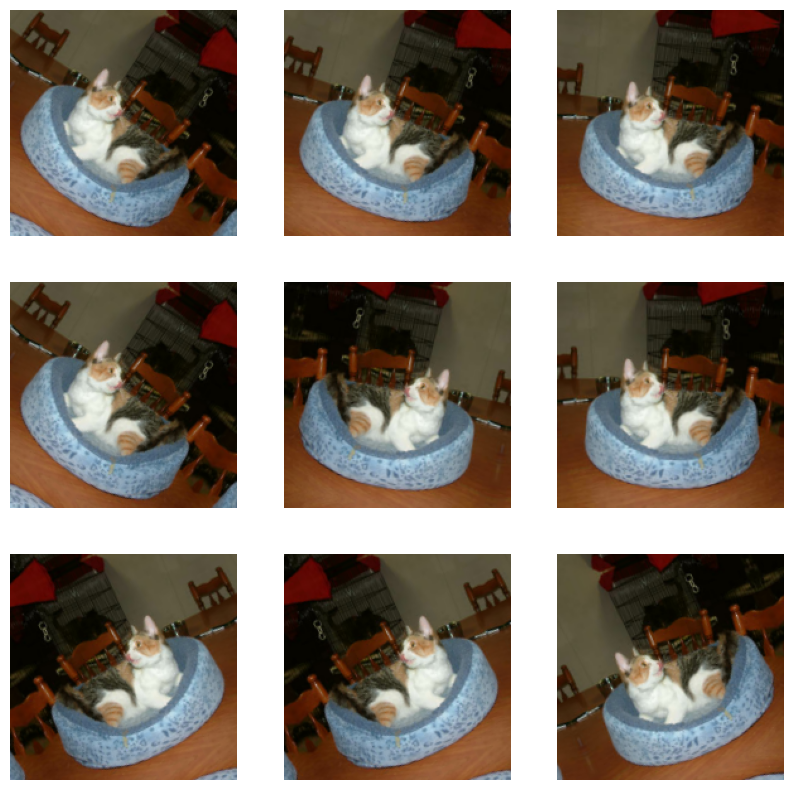

In [10]:
# let's visualize one augmentated image 
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis("off")

In [11]:
# Applying data augmentation to trainingd dataset 
train_ds = train_ds.map (
 lambda img, label: (data_augmentation(img), label))

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

The `tf.data` API provides the `tf.data.Dataset.prefetch` transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to `tf.data.AUTOTUNE`, which will prompt the `tf.data` runtime to tune the value dynamically at runtime.

## Building Our Model

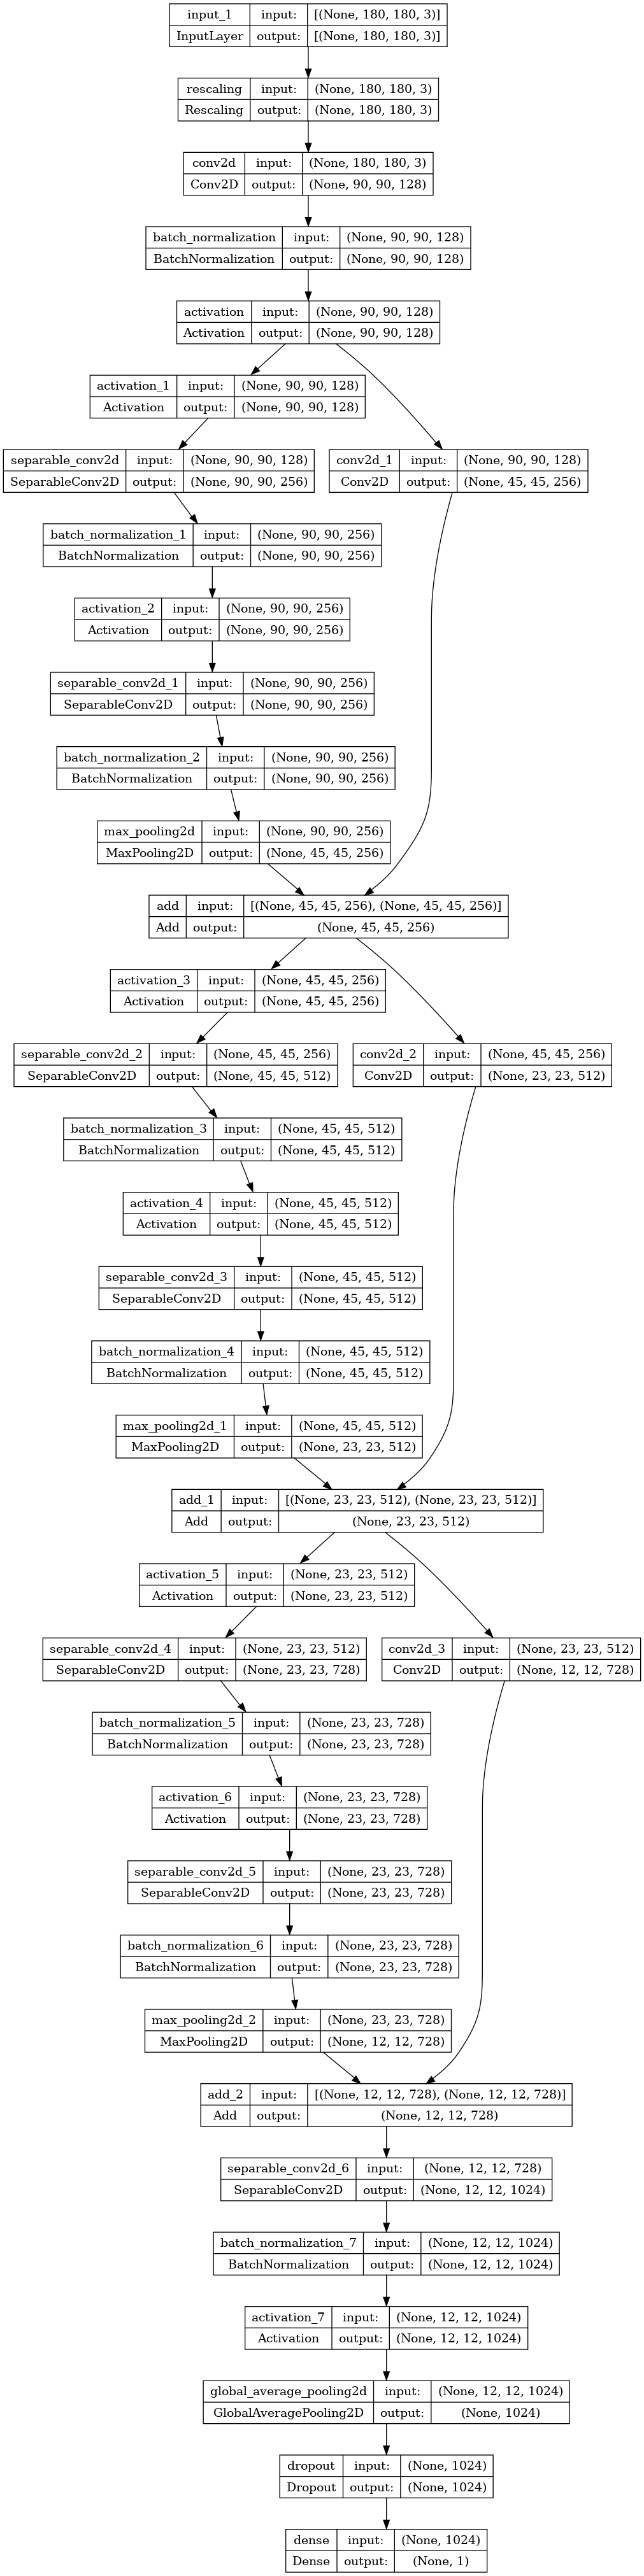

In [12]:
def make_model(input_shape, num_classes):
    
    inputs = keras.Input(shape=input_shape)
    
    # entry block layers
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides = 2, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    previous_block_activation = x 
    
    for size in [256, 512, 728]:
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding = 'same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides = 2, padding = 'same')(x)
        
        residual = layers.Conv2D(size, 1, strides = 2, padding = "same")(previous_block_activation)
        
        x = layers.add([x, residual])
        
        previous_block_activation = x 
        
    x = layers.SeparableConv2D(1024, 3, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1 
        
    else:
        activation = "softmax"
        units = num_classes
        
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation = activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape = image_size + (3,), num_classes = 2) 
keras.utils.plot_model(model, show_shapes = True)

In [13]:
## Train the model 

callbacks = [keras.callbacks.ModelCheckpoint("save_at{epoch}.keras"),]

model.compile(
   
    optimizer = keras.optimizers.Adam(1e-3),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [keras.metrics.Accuracy()]
)

history = model.fit(train_ds, 
                   epochs = 25,
                   callbacks = callbacks,
                   validation_data = val_ds)

Epoch 1/25
 13/147 [=>............................] - ETA: 3:45 - loss: 0.7676 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 42/147 [=======>......................] - ETA: 3:06 - loss: 0.7196 - accuracy: 0.0000e+00

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 2:04 - loss: 0.7012 - accuracy: 0.0000e+00

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/147 [===============>..............] - ETA: 1:56 - loss: 0.6976 - accuracy: 0.0000e+00

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:42 - loss: 0.6895 - accuracy: 0.0000e+00

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:19 - loss: 0.6789 - accuracy: 0.0000e+00

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 1:04 - loss: 0.6787 - accuracy: 0.0000e+00

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 53s - loss: 0.6767 - accuracy: 0.0000e+00

122/147 [=======================>......] - ETA: 44s - loss: 0.6746 - accuracy: 0.0000e+00

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 21s - loss: 0.6670 - accuracy: 0.0000e+00

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.6620 - accuracy: 0.0000e+00

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 325s 2s/step - loss: 0.6620 - accuracy: 0.0000e+00 - val_loss: 0.7753 - val_accuracy: 0.0000e+00
Epoch 2/25
 13/147 [=>............................] - ETA: 4:01 - loss: 0.5657 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 42/147 [=======>......................] - ETA: 3:10 - loss: 0.5554 - accuracy: 0.0000e+00

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 2:06 - loss: 0.5406 - accuracy: 0.0000e+00

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/147 [===============>..............] - ETA: 1:57 - loss: 0.5354 - accuracy: 0.0000e+00

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:43 - loss: 0.5292 - accuracy: 0.0000e+00

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:19 - loss: 0.5200 - accuracy: 0.0000e+00

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 1:05 - loss: 0.5142 - accuracy: 0.0000e+00

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 54s - loss: 0.5110 - accuracy: 0.0000e+00

122/147 [=======================>......] - ETA: 45s - loss: 0.5093 - accuracy: 0.0000e+00

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 21s - loss: 0.5037 - accuracy: 0.0000e+00

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.4988 - accuracy: 0.0000e+00

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 282s 2s/step - loss: 0.4988 - accuracy: 0.0000e+00 - val_loss: 0.9453 - val_accuracy: 0.0000e+00
Epoch 3/25
 13/147 [=>............................] - ETA: 4:02 - loss: 0.4163 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 42/147 [=======>......................] - ETA: 3:09 - loss: 0.4221 - accuracy: 0.0000e+00

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 2:06 - loss: 0.4150 - accuracy: 0.0000e+00

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/147 [===============>..............] - ETA: 1:57 - loss: 0.4116 - accuracy: 0.0000e+00

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:43 - loss: 0.4077 - accuracy: 0.0000e+00

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:19 - loss: 0.4017 - accuracy: 0.0000e+00

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 1:05 - loss: 0.3997 - accuracy: 0.0000e+00

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 54s - loss: 0.3991 - accuracy: 0.0000e+00

122/147 [=======================>......] - ETA: 45s - loss: 0.3986 - accuracy: 0.0000e+00

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 21s - loss: 0.3957 - accuracy: 0.0000e+00

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.3934 - accuracy: 0.0000e+00

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 281s 2s/step - loss: 0.3934 - accuracy: 0.0000e+00 - val_loss: 0.9269 - val_accuracy: 0.0000e+00
Epoch 4/25
 12/147 [=>............................] - ETA: 3:36 - loss: 0.3682 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 41/147 [=======>......................] - ETA: 2:37 - loss: 0.3581 - accuracy: 0.0000e+00

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 76/147 [==============>...............] - ETA: 1:42 - loss: 0.3414 - accuracy: 0.0000e+00

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/147 [===============>..............] - ETA: 1:35 - loss: 0.3385 - accuracy: 0.0000e+00

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/147 [=================>............] - ETA: 1:23 - loss: 0.3354 - accuracy: 0.0000e+00

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 1:05 - loss: 0.3316 - accuracy: 0.0000e+00

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


110/147 [=====================>........] - ETA: 53s - loss: 0.3308 - accuracy: 0.0000e+00

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 43s - loss: 0.3294 - accuracy: 0.0000e+00

121/147 [=======================>......] - ETA: 38s - loss: 0.3272 - accuracy: 0.0000e+00

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 17s - loss: 0.3287 - accuracy: 0.0000e+00

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.3264 - accuracy: 0.0000e+00

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 235s 2s/step - loss: 0.3264 - accuracy: 0.0000e+00 - val_loss: 0.9229 - val_accuracy: 0.0000e+00
Epoch 5/25
 13/147 [=>............................] - ETA: 3:59 - loss: 0.3054 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 41/147 [=======>......................] - ETA: 2:50 - loss: 0.2955 - accuracy: 0.0000e+00

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 76/147 [==============>...............] - ETA: 1:47 - loss: 0.2858 - accuracy: 2.0559e-04

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/147 [===============>..............] - ETA: 1:39 - loss: 0.2841 - accuracy: 1.9290e-04

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/147 [=================>............] - ETA: 1:27 - loss: 0.2806 - accuracy: 1.7556e-04

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:05 - loss: 0.2766 - accuracy: 2.2755e-04

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 54s - loss: 0.2762 - accuracy: 2.1115e-04

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 45s - loss: 0.2757 - accuracy: 2.0032e-04

122/147 [=======================>......] - ETA: 37s - loss: 0.2743 - accuracy: 1.9211e-04

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 18s - loss: 0.2734 - accuracy: 2.3148e-04

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.2730 - accuracy: 2.1358e-04

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 242s 2s/step - loss: 0.2730 - accuracy: 2.1358e-04 - val_loss: 0.3465 - val_accuracy: 0.0000e+00
Epoch 6/25
 13/147 [=>............................] - ETA: 4:01 - loss: 0.2805 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 42/147 [=======>......................] - ETA: 3:10 - loss: 0.2544 - accuracy: 1.8601e-04

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 2:07 - loss: 0.2444 - accuracy: 1.0146e-04

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/147 [===============>..............] - ETA: 1:58 - loss: 0.2442 - accuracy: 9.5274e-05

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:43 - loss: 0.2416 - accuracy: 8.6806e-05

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:20 - loss: 0.2380 - accuracy: 7.5850e-05

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 1:05 - loss: 0.2358 - accuracy: 1.4077e-04

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 54s - loss: 0.2353 - accuracy: 1.3355e-04

122/147 [=======================>......] - ETA: 45s - loss: 0.2347 - accuracy: 1.2807e-04

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 21s - loss: 0.2359 - accuracy: 1.7361e-04

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.2363 - accuracy: 1.6019e-04

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 283s 2s/step - loss: 0.2363 - accuracy: 1.6019e-04 - val_loss: 0.4900 - val_accuracy: 2.1358e-04
Epoch 7/25
 13/147 [=>............................] - ETA: 4:06 - loss: 0.2163 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 42/147 [=======>......................] - ETA: 2:51 - loss: 0.2144 - accuracy: 0.0000e+00

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 76/147 [==============>...............] - ETA: 1:53 - loss: 0.2057 - accuracy: 3.0839e-04

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/147 [===============>..............] - ETA: 1:43 - loss: 0.2045 - accuracy: 2.8582e-04

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:30 - loss: 0.2021 - accuracy: 2.6042e-04

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 1:10 - loss: 0.1989 - accuracy: 2.2978e-04

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


110/147 [=====================>........] - ETA: 57s - loss: 0.1983 - accuracy: 2.1307e-04

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


116/147 [======================>.......] - ETA: 48s - loss: 0.1968 - accuracy: 3.3675e-04

122/147 [=======================>......] - ETA: 38s - loss: 0.1978 - accuracy: 3.8422e-04

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


134/147 [==========================>...] - ETA: 19s - loss: 0.1979 - accuracy: 4.0812e-04

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 3.7377e-04

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 241s 2s/step - loss: 0.1991 - accuracy: 3.7377e-04 - val_loss: 0.2001 - val_accuracy: 0.0013
Epoch 8/25
 13/147 [=>............................] - ETA: 4:02 - loss: 0.2019 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 41/147 [=======>......................] - ETA: 2:50 - loss: 0.1884 - accuracy: 5.7165e-04

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 76/147 [==============>...............] - ETA: 1:51 - loss: 0.1898 - accuracy: 4.1118e-04

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/147 [===============>..............] - ETA: 1:43 - loss: 0.1875 - accuracy: 3.8580e-04

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:28 - loss: 0.1864 - accuracy: 5.2083e-04

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 1:08 - loss: 0.1854 - accuracy: 6.1275e-04

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


110/147 [=====================>........] - ETA: 56s - loss: 0.1834 - accuracy: 6.3920e-04

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


116/147 [======================>.......] - ETA: 47s - loss: 0.1820 - accuracy: 7.4084e-04

121/147 [=======================>......] - ETA: 39s - loss: 0.1815 - accuracy: 9.0393e-04

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


134/147 [==========================>...] - ETA: 19s - loss: 0.1823 - accuracy: 9.3284e-04

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1830 - accuracy: 9.6113e-04

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 237s 2s/step - loss: 0.1830 - accuracy: 9.6113e-04 - val_loss: 0.7006 - val_accuracy: 0.0581
Epoch 9/25
 13/147 [=>............................] - ETA: 4:00 - loss: 0.1756 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 42/147 [=======>......................] - ETA: 3:09 - loss: 0.1806 - accuracy: 7.4405e-04

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 2:07 - loss: 0.1759 - accuracy: 6.0877e-04

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/147 [===============>..............] - ETA: 1:57 - loss: 0.1744 - accuracy: 5.7165e-04

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:43 - loss: 0.1722 - accuracy: 8.6806e-04

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:19 - loss: 0.1716 - accuracy: 0.0011

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 1:05 - loss: 0.1688 - accuracy: 0.0012

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 54s - loss: 0.1693 - accuracy: 0.0012

122/147 [=======================>......] - ETA: 45s - loss: 0.1702 - accuracy: 0.0012

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 21s - loss: 0.1723 - accuracy: 0.0012

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.0012

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 283s 2s/step - loss: 0.1741 - accuracy: 0.0012 - val_loss: 0.3272 - val_accuracy: 0.0000e+00
Epoch 10/25
 13/147 [=>............................] - ETA: 4:04 - loss: 0.2147 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 41/147 [=======>......................] - ETA: 2:52 - loss: 0.1728 - accuracy: 0.0011

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 1:46 - loss: 0.1676 - accuracy: 9.1315e-04

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/147 [===============>..............] - ETA: 1:40 - loss: 0.1660 - accuracy: 9.6451e-04

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/147 [=================>............] - ETA: 1:27 - loss: 0.1633 - accuracy: 0.0011

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:06 - loss: 0.1568 - accuracy: 0.0020

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


110/147 [=====================>........] - ETA: 55s - loss: 0.1580 - accuracy: 0.0019

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


116/147 [======================>.......] - ETA: 46s - loss: 0.1580 - accuracy: 0.0018

122/147 [=======================>......] - ETA: 37s - loss: 0.1588 - accuracy: 0.0018

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 18s - loss: 0.1597 - accuracy: 0.0019

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.0019

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 249s 2s/step - loss: 0.1589 - accuracy: 0.0019 - val_loss: 0.1507 - val_accuracy: 0.0011
Epoch 11/25
 12/147 [=>............................] - ETA: 3:45 - loss: 0.1612 - accuracy: 0.0033

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 41/147 [=======>......................] - ETA: 2:56 - loss: 0.1616 - accuracy: 0.0042

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 76/147 [==============>...............] - ETA: 1:49 - loss: 0.1557 - accuracy: 0.0035

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/147 [===============>..............] - ETA: 1:41 - loss: 0.1526 - accuracy: 0.0036

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/147 [=================>............] - ETA: 1:28 - loss: 0.1523 - accuracy: 0.0036

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:06 - loss: 0.1492 - accuracy: 0.0038

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


110/147 [=====================>........] - ETA: 56s - loss: 0.1476 - accuracy: 0.0036

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


116/147 [======================>.......] - ETA: 46s - loss: 0.1482 - accuracy: 0.0036

122/147 [=======================>......] - ETA: 37s - loss: 0.1472 - accuracy: 0.0037

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


134/147 [==========================>...] - ETA: 19s - loss: 0.1468 - accuracy: 0.0037

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.0037

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 239s 2s/step - loss: 0.1461 - accuracy: 0.0037 - val_loss: 0.1527 - val_accuracy: 0.0105
Epoch 12/25
 13/147 [=>............................] - ETA: 4:03 - loss: 0.1697 - accuracy: 0.0060

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 42/147 [=======>......................] - ETA: 3:11 - loss: 0.1595 - accuracy: 0.0024

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 2:07 - loss: 0.1522 - accuracy: 0.0022

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/147 [===============>..............] - ETA: 1:58 - loss: 0.1504 - accuracy: 0.0023

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:43 - loss: 0.1463 - accuracy: 0.0023

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:19 - loss: 0.1461 - accuracy: 0.0027

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 1:05 - loss: 0.1448 - accuracy: 0.0028

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 54s - loss: 0.1451 - accuracy: 0.0027

122/147 [=======================>......] - ETA: 45s - loss: 0.1458 - accuracy: 0.0026

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 21s - loss: 0.1456 - accuracy: 0.0027

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.0032

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 282s 2s/step - loss: 0.1455 - accuracy: 0.0032 - val_loss: 0.1249 - val_accuracy: 0.0124
Epoch 13/25
 12/147 [=>............................] - ETA: 3:38 - loss: 0.1753 - accuracy: 0.0013

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 41/147 [=======>......................] - ETA: 2:35 - loss: 0.1452 - accuracy: 0.0015

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 76/147 [==============>...............] - ETA: 1:43 - loss: 0.1297 - accuracy: 0.0029

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/147 [===============>..............] - ETA: 1:35 - loss: 0.1264 - accuracy: 0.0035

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:22 - loss: 0.1240 - accuracy: 0.0040

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:03 - loss: 0.1212 - accuracy: 0.0048

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 52s - loss: 0.1207 - accuracy: 0.0052

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 44s - loss: 0.1206 - accuracy: 0.0054

122/147 [=======================>......] - ETA: 37s - loss: 0.1205 - accuracy: 0.0056

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


134/147 [==========================>...] - ETA: 19s - loss: 0.1209 - accuracy: 0.0065

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.0065

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 237s 2s/step - loss: 0.1211 - accuracy: 0.0065 - val_loss: 0.1314 - val_accuracy: 0.0105
Epoch 14/25
 13/147 [=>............................] - ETA: 3:59 - loss: 0.1391 - accuracy: 0.0132

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 42/147 [=======>......................] - ETA: 3:10 - loss: 0.1307 - accuracy: 0.0067

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 2:06 - loss: 0.1267 - accuracy: 0.0063

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/147 [===============>..............] - ETA: 1:57 - loss: 0.1244 - accuracy: 0.0065

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:43 - loss: 0.1236 - accuracy: 0.0066

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:19 - loss: 0.1231 - accuracy: 0.0068

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 1:05 - loss: 0.1225 - accuracy: 0.0070

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 54s - loss: 0.1231 - accuracy: 0.0077

122/147 [=======================>......] - ETA: 45s - loss: 0.1225 - accuracy: 0.0078

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 21s - loss: 0.1228 - accuracy: 0.0081

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.0082

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 281s 2s/step - loss: 0.1231 - accuracy: 0.0082 - val_loss: 0.1496 - val_accuracy: 0.0013
Epoch 15/25
 12/147 [=>............................] - ETA: 3:45 - loss: 0.1677 - accuracy: 0.0052

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 42/147 [=======>......................] - ETA: 2:42 - loss: 0.1386 - accuracy: 0.0052

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 76/147 [==============>...............] - ETA: 1:47 - loss: 0.1297 - accuracy: 0.0064

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/147 [===============>..............] - ETA: 1:38 - loss: 0.1271 - accuracy: 0.0065

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/147 [=================>............] - ETA: 1:27 - loss: 0.1271 - accuracy: 0.0070

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 1:07 - loss: 0.1237 - accuracy: 0.0070

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


110/147 [=====================>........] - ETA: 54s - loss: 0.1226 - accuracy: 0.0070

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


116/147 [======================>.......] - ETA: 45s - loss: 0.1209 - accuracy: 0.0075

122/147 [=======================>......] - ETA: 36s - loss: 0.1209 - accuracy: 0.0077

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


134/147 [==========================>...] - ETA: 19s - loss: 0.1204 - accuracy: 0.0087

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.0088

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 232s 2s/step - loss: 0.1200 - accuracy: 0.0088 - val_loss: 0.1827 - val_accuracy: 0.0092
Epoch 16/25
 13/147 [=>............................] - ETA: 3:36 - loss: 0.1255 - accuracy: 0.0114

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 41/147 [=======>......................] - ETA: 2:41 - loss: 0.1197 - accuracy: 0.0103

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 76/147 [==============>...............] - ETA: 1:43 - loss: 0.1209 - accuracy: 0.0084

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/147 [===============>..............] - ETA: 1:36 - loss: 0.1189 - accuracy: 0.0085

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/147 [=================>............] - ETA: 1:24 - loss: 0.1194 - accuracy: 0.0090

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 1:05 - loss: 0.1173 - accuracy: 0.0090

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


110/147 [=====================>........] - ETA: 53s - loss: 0.1159 - accuracy: 0.0090

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


116/147 [======================>.......] - ETA: 44s - loss: 0.1152 - accuracy: 0.0092

121/147 [=======================>......] - ETA: 37s - loss: 0.1147 - accuracy: 0.0092

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 17s - loss: 0.1149 - accuracy: 0.0093

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.0092

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 227s 2s/step - loss: 0.1151 - accuracy: 0.0092 - val_loss: 0.1901 - val_accuracy: 8.5434e-04
Epoch 17/25
 13/147 [=>............................] - ETA: 3:59 - loss: 0.1095 - accuracy: 0.0078

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 42/147 [=======>......................] - ETA: 3:08 - loss: 0.1098 - accuracy: 0.0084

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 2:06 - loss: 0.1082 - accuracy: 0.0100

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/147 [===============>..............] - ETA: 1:57 - loss: 0.1067 - accuracy: 0.0106

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:42 - loss: 0.1056 - accuracy: 0.0113

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:19 - loss: 0.1058 - accuracy: 0.0118

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 1:04 - loss: 0.1040 - accuracy: 0.0122

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 54s - loss: 0.1047 - accuracy: 0.0128

122/147 [=======================>......] - ETA: 45s - loss: 0.1051 - accuracy: 0.0128

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 21s - loss: 0.1042 - accuracy: 0.0137

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.0135

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 281s 2s/step - loss: 0.1033 - accuracy: 0.0135 - val_loss: 0.1417 - val_accuracy: 0.0229
Epoch 18/25
 13/147 [=>............................] - ETA: 4:01 - loss: 0.1111 - accuracy: 0.0114

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 42/147 [=======>......................] - ETA: 3:09 - loss: 0.1122 - accuracy: 0.0112

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 2:06 - loss: 0.1074 - accuracy: 0.0099

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/147 [===============>..............] - ETA: 1:57 - loss: 0.1060 - accuracy: 0.0102

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:42 - loss: 0.1061 - accuracy: 0.0106

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:19 - loss: 0.1045 - accuracy: 0.0107

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 1:04 - loss: 0.1041 - accuracy: 0.0113

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 54s - loss: 0.1036 - accuracy: 0.0114

122/147 [=======================>......] - ETA: 45s - loss: 0.1040 - accuracy: 0.0118

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 21s - loss: 0.1023 - accuracy: 0.0123

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.0126

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 281s 2s/step - loss: 0.1024 - accuracy: 0.0126 - val_loss: 0.1468 - val_accuracy: 0.0023
Epoch 19/25
 13/147 [=>............................] - ETA: 4:05 - loss: 0.1269 - accuracy: 0.0162

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 42/147 [=======>......................] - ETA: 3:11 - loss: 0.1166 - accuracy: 0.0145

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 2:07 - loss: 0.1053 - accuracy: 0.0135

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/147 [===============>..............] - ETA: 1:58 - loss: 0.1035 - accuracy: 0.0136

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:43 - loss: 0.1026 - accuracy: 0.0138

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:19 - loss: 0.1034 - accuracy: 0.0143

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 1:05 - loss: 0.1042 - accuracy: 0.0149

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 54s - loss: 0.1041 - accuracy: 0.0147

122/147 [=======================>......] - ETA: 45s - loss: 0.1037 - accuracy: 0.0149

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 21s - loss: 0.1044 - accuracy: 0.0155

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.0155

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 282s 2s/step - loss: 0.1031 - accuracy: 0.0155 - val_loss: 0.1123 - val_accuracy: 0.0036
Epoch 20/25
 13/147 [=>............................] - ETA: 4:00 - loss: 0.0942 - accuracy: 0.0180

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 42/147 [=======>......................] - ETA: 3:09 - loss: 0.0919 - accuracy: 0.0164

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 2:06 - loss: 0.0948 - accuracy: 0.0160

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/147 [===============>..............] - ETA: 1:57 - loss: 0.0936 - accuracy: 0.0171

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:43 - loss: 0.0926 - accuracy: 0.0170

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:19 - loss: 0.0917 - accuracy: 0.0181

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 1:05 - loss: 0.0917 - accuracy: 0.0185

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 54s - loss: 0.0914 - accuracy: 0.0187

122/147 [=======================>......] - ETA: 45s - loss: 0.0916 - accuracy: 0.0195

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 21s - loss: 0.0943 - accuracy: 0.0203

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.0203

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 282s 2s/step - loss: 0.0937 - accuracy: 0.0203 - val_loss: 0.6347 - val_accuracy: 0.1937
Epoch 21/25
 12/147 [=>............................] - ETA: 4:05 - loss: 0.0982 - accuracy: 0.0195

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 41/147 [=======>......................] - ETA: 2:43 - loss: 0.0977 - accuracy: 0.0185

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 1:45 - loss: 0.0943 - accuracy: 0.0207

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/147 [===============>..............] - ETA: 1:39 - loss: 0.0943 - accuracy: 0.0201

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:25 - loss: 0.0954 - accuracy: 0.0204

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 1:08 - loss: 0.0930 - accuracy: 0.0207

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 54s - loss: 0.0943 - accuracy: 0.0209

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


116/147 [======================>.......] - ETA: 47s - loss: 0.0943 - accuracy: 0.0211

122/147 [=======================>......] - ETA: 37s - loss: 0.0965 - accuracy: 0.0215

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 18s - loss: 0.0958 - accuracy: 0.0211

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.0213

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 239s 2s/step - loss: 0.0964 - accuracy: 0.0213 - val_loss: 0.1464 - val_accuracy: 0.0015
Epoch 22/25
 12/147 [=>............................] - ETA: 3:44 - loss: 0.1169 - accuracy: 0.0182

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 42/147 [=======>......................] - ETA: 2:37 - loss: 0.1000 - accuracy: 0.0246

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 76/147 [==============>...............] - ETA: 1:46 - loss: 0.0954 - accuracy: 0.0254

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/147 [===============>..............] - ETA: 1:38 - loss: 0.0936 - accuracy: 0.0258

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/147 [=================>............] - ETA: 1:26 - loss: 0.0923 - accuracy: 0.0252

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 1:06 - loss: 0.0901 - accuracy: 0.0245

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 53s - loss: 0.0892 - accuracy: 0.0243

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 44s - loss: 0.0888 - accuracy: 0.0241

122/147 [=======================>......] - ETA: 37s - loss: 0.0878 - accuracy: 0.0245

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 18s - loss: 0.0878 - accuracy: 0.0248

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.0248

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 237s 2s/step - loss: 0.0884 - accuracy: 0.0248 - val_loss: 0.2772 - val_accuracy: 0.0419
Epoch 23/25
 13/147 [=>............................] - ETA: 3:40 - loss: 0.1430 - accuracy: 0.0252

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 41/147 [=======>......................] - ETA: 2:49 - loss: 0.1130 - accuracy: 0.0219

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 1:46 - loss: 0.1017 - accuracy: 0.0206

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/147 [===============>..............] - ETA: 1:39 - loss: 0.1002 - accuracy: 0.0218

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:28 - loss: 0.0972 - accuracy: 0.0230

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 1:09 - loss: 0.0975 - accuracy: 0.0236

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


110/147 [=====================>........] - ETA: 56s - loss: 0.0961 - accuracy: 0.0238

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


116/147 [======================>.......] - ETA: 47s - loss: 0.0947 - accuracy: 0.0242

122/147 [=======================>......] - ETA: 38s - loss: 0.0937 - accuracy: 0.0247

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


134/147 [==========================>...] - ETA: 19s - loss: 0.0936 - accuracy: 0.0250

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.0253

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 237s 2s/step - loss: 0.0926 - accuracy: 0.0253 - val_loss: 0.1092 - val_accuracy: 0.0128
Epoch 24/25
 13/147 [=>............................] - ETA: 3:59 - loss: 0.0977 - accuracy: 0.0306

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 41/147 [=======>......................] - ETA: 2:55 - loss: 0.0954 - accuracy: 0.0274

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 76/147 [==============>...............] - ETA: 1:50 - loss: 0.0903 - accuracy: 0.0251

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/147 [===============>..............] - ETA: 1:41 - loss: 0.0881 - accuracy: 0.0255

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:28 - loss: 0.0857 - accuracy: 0.0268

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 1:09 - loss: 0.0859 - accuracy: 0.0278

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


110/147 [=====================>........] - ETA: 56s - loss: 0.0848 - accuracy: 0.0273

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


116/147 [======================>.......] - ETA: 47s - loss: 0.0830 - accuracy: 0.0271

122/147 [=======================>......] - ETA: 38s - loss: 0.0831 - accuracy: 0.0270

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 18s - loss: 0.0823 - accuracy: 0.0280

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.0815 - accuracy: 0.0277

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 237s 2s/step - loss: 0.0815 - accuracy: 0.0277 - val_loss: 0.2014 - val_accuracy: 0.1074
Epoch 25/25
 13/147 [=>............................] - ETA: 4:00 - loss: 0.1107 - accuracy: 0.0445

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 42/147 [=======>......................] - ETA: 3:08 - loss: 0.0873 - accuracy: 0.0350

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 2:06 - loss: 0.0808 - accuracy: 0.0352

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/147 [===============>..............] - ETA: 1:57 - loss: 0.0804 - accuracy: 0.0353

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/147 [=================>............] - ETA: 1:42 - loss: 0.0796 - accuracy: 0.0354

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 1:19 - loss: 0.0793 - accuracy: 0.0341

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/147 [=====================>........] - ETA: 1:05 - loss: 0.0788 - accuracy: 0.0344

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


117/147 [======================>.......] - ETA: 54s - loss: 0.0801 - accuracy: 0.0352

122/147 [=======================>......] - ETA: 45s - loss: 0.0797 - accuracy: 0.0354

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


135/147 [==========================>...] - ETA: 21s - loss: 0.0815 - accuracy: 0.0345

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.0336

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


147/147 [==============================] - 281s 2s/step - loss: 0.0819 - accuracy: 0.0336 - val_loss: 0.1407 - val_accuracy: 0.0075


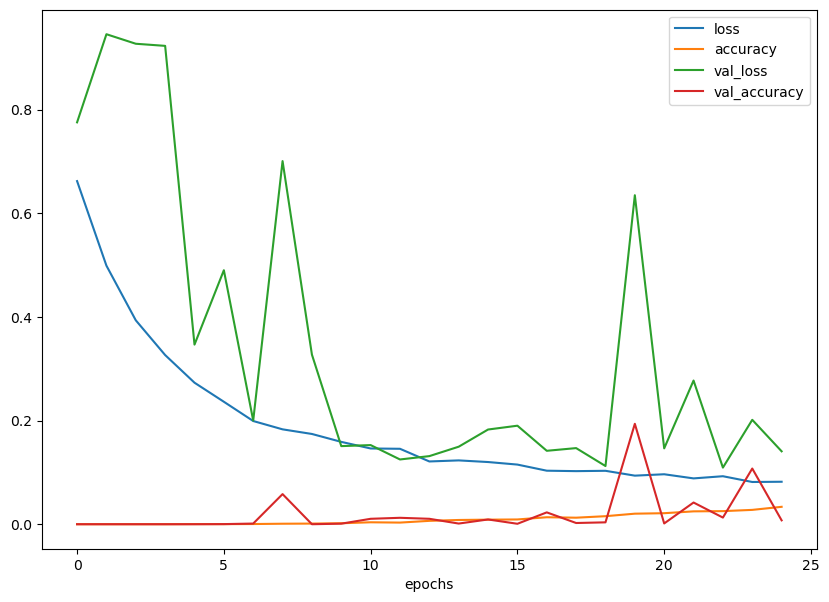

In [16]:
# Checkout the history
import pandas as pd 
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs");

In [14]:
img = keras.utils.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 1s 942ms/step
This image is 82.78% cat and 17.22% dog.


Example Project Taken From Here: https://keras.io/examples/vision/image_classification_from_scratch/